<a href="https://www.kaggle.com/code/mustafacihadgoktepe/chest-x-ray-images-pneumonia?scriptVersionId=108382330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/'

val_datagen = ImageDataGenerator(rescale=1/255)

val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(150, 150))

test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                   target_size=(150, 150))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
train_generator.class_indices

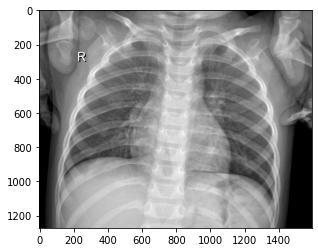

In [5]:
img_dir ='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0219-0001.jpeg'

plt.imshow(plt.imread(img_dir), cmap='gray');

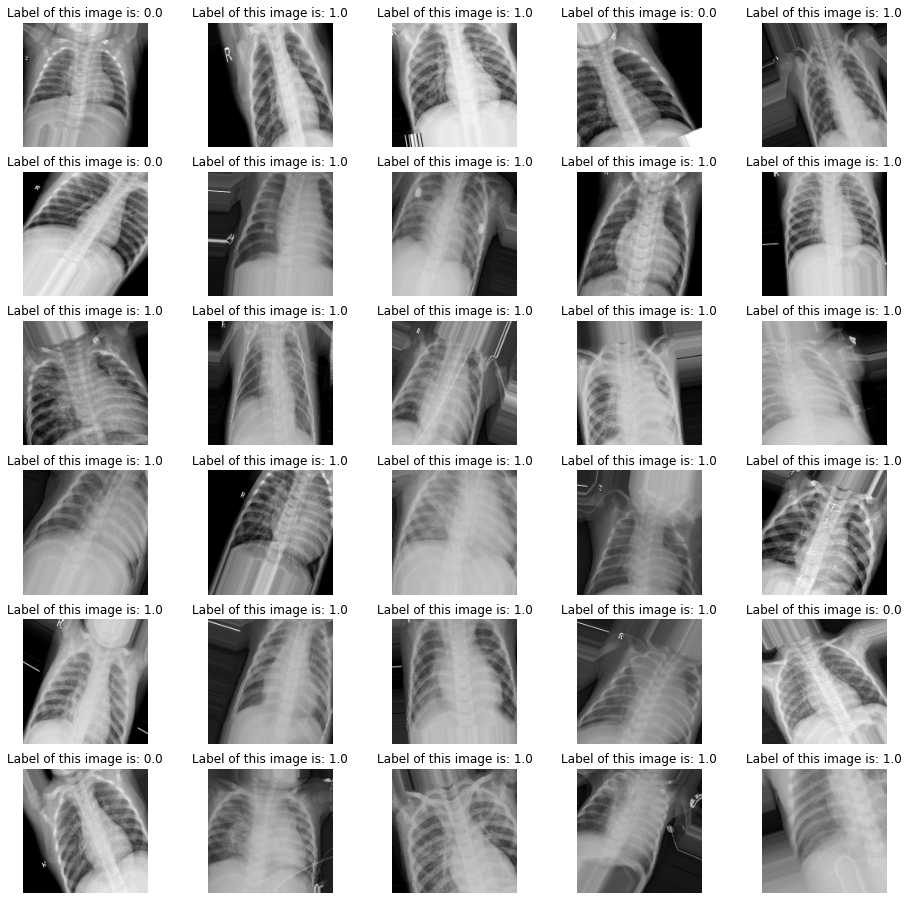

In [6]:
plt.figure(figsize=(16,16))
plt.tight_layout()

data = train_generator.next()
image = data[0]
label =data[1]

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.axis('off')
    plt.title('Label of this image is: ' + str(label[i]))
    plt.imshow(image[i], cmap='gray')

In [7]:
from collections import Counter

counter = Counter(train_generator.classes)
counter

Counter({0: 1341, 1: 3875})

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


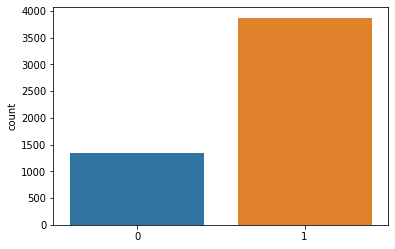

In [8]:
sns.countplot(train_generator.classes);

In [9]:
from tensorflow.keras import Sequential, layers, callbacks, metrics, optimizers, losses

model = Sequential([
    layers.BatchNormalization(input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
]) 

model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(),
                       metrics.AUC(),
                       metrics.Precision(),
                       metrics.Recall()])
              
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

lr_sch = callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 2, factor = np.sqrt(0.2), verbose = 1,
                                     min_lr = 5e-10)

model.summary()

2022-10-17 19:20:18.113935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 19:20:18.350525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 19:20:18.351367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 19:20:18.353214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

In [14]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train_generator.classes),
                                                 y = train_generator.classes)

class_weights

array([1.9448173 , 0.67303226])

In [16]:
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight = class_weights,
    callbacks=[early_stopping, lr_sch]
)

2022-10-17 19:21:24.176992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-17 19:21:27.928520: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 124s 704ms/step - loss: 0.3811 - binary_accuracy: 0.8244 - auc: 0.9191 - precision: 0.9526 - recall: 0.8036 - val_loss: 5.2459 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
163/163 [==============================] - 84s 517ms/step - loss: 0.2923 - binary_accuracy: 0.8765 - auc: 0.9475 - precision: 0.9679 - recall: 0.8625 - val_loss: 3.5780 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
163/163 [==============================] - 84s 514ms/step - loss: 0.2531 - binary_accuracy: 0.8967 - auc: 0.9606 - precision: 0.9701 - recall: 0.8883 - val_loss: 2.3832 - val_binary_accuracy: 0.5625 - val_auc: 0.6484 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 4/100
163/163 [==============================] - 84s 513ms/step - loss: 0.2367 - binary_accuracy: 0.9020 - auc: 0.9646 - precision: 0.9698 - recall: 0.8960 - val_loss: 1.1501 - val_bi

In [18]:
history_df = pd.DataFrame(history.history)
history_df

,loss,binary_accuracy,auc,precision,recall,val_loss,val_binary_accuracy,val_auc,val_precision,val_recall,lr
0,0.381060,0.824386,0.919149,0.952585,0.803613,5.245872,0.5000,0.500000,0.500000,1.000,0.001000
1,0.292272,0.876534,0.947498,0.967854,0.862452,3.578005,0.5000,0.500000,0.500000,1.000,0.001000
2,0.253128,0.896664,0.960600,0.970124,0.888258,2.383157,0.5625,0.648438,0.533333,1.000,0.001000
3,0.236696,0.902032,0.964601,0.969832,0.896000,1.150096,0.5625,0.867188,0.533333,1.000,0.001000
4,0.228491,0.904525,0.966790,0.970203,0.899097,1.892345,0.5625,0.625000,1.000000,0.125,0.001000
5,0.226934,0.908742,0.967974,0.970906,0.904258,2.145907,0.5625,0.687500,0.533333,1.000,0.001000
6,0.191522,0.918328,0.976853,0.978363,0.910194,0.621309,0.5625,0.687500,0.571429,0.500,0.000447
7,0.186386,0.927531,0.977342,0.980225,0.921032,0.487247,0.8125,0.906250,1.000000,0.625,0.000447
8,0.193993,0.921396,0.975553,0.976879,0.915871,1.787599,0.5625,0.687500,0.533333,1.000,0.000447
9,0.167556,0.936350,0.981653,0.982303,0.931097,1.643592,0.6250,0.750000,0.571429,1.000,0.000447


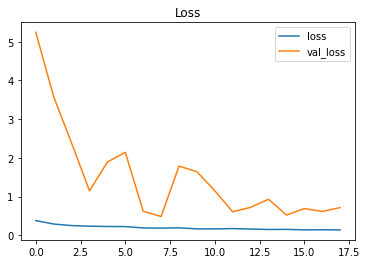

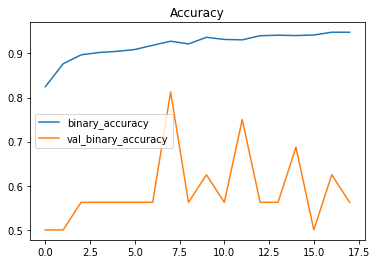

In [22]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss");
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy");


In [23]:
model.evaluate(test_generator)

20/20 [==============================] - 9s 448ms/step - loss: 0.3947 - binary_accuracy: 0.8462 - auc: 0.9519 - precision: 0.9652 - recall: 0.7821


[0.39473479986190796,
 0.8461538553237915,
 0.9519450068473816,
 0.9651898741722107,
 0.7820512652397156]

In [24]:
preds = model.predict(test_generator)

In [27]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1

In [21]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [22]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [23]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [36]:
from keras.preprocessing import image

img_dir_ = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0073-0001.jpeg'
img_width, img_height = 150, 150

img = image.load_img(img_dir_, target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

pred_ = model.predict(img)
pred_

array([[0.]], dtype=float32)

Thanks for reading.